In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import keras
import os
import random
import shutil
import sklearn

from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, Activation, MaxPooling2D

2024-05-31 16:29:17.028500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 16:29:17.068664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 16:29:17.849262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# In order to rebalance the sets train/test/val to 80/10/10 I used the code provided by
# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/discussion/485689

new_dataset_path = "../data/"
dataset_path = "../data_old/"

if not os.path.exists(new_dataset_path):
    for split in ["train", "val", "test"]:
        for cls in ["NORMAL", "PNEUMONIA"]:
            os.makedirs(f"{new_dataset_path}/{split}/{cls}", exist_ok=True)

    for cls in ["NORMAL", "PNEUMONIA"]:
        all_files = []
        for split in ["train", "val", "test"]:
            source_folder = f"{dataset_path}/{split}/{cls}"
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        random.shuffle(all_files)

        train_files = all_files[: int(len(all_files) * 0.8)]
        val_files = all_files[int(len(all_files) * 0.8) : int(len(all_files) * 0.9)]
        test_files = all_files[int(len(all_files) * 0.9) :]

        for file, source_folder in train_files:
            dest = f"{new_dataset_path}/train/{cls}/{file}"
            shutil.copy(f"{source_folder}/{file}", dest)

        for file, source_folder in val_files:
            dest = f"{new_dataset_path}/val/{cls}/{file}"
            shutil.copy(f"{source_folder}/{file}", dest)

        for file, source_folder in test_files:
            dest = f"{new_dataset_path}/test/{cls}/{file}"
            shutil.copy(f"{source_folder}/{file}", dest)

In [9]:
image_size = 224
batch_size = 16


def load_data(directory, shuffle=True):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    ).flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
    )


train = load_data("../data/train")
val = load_data("../data/val")
test = load_data("../data/test", shuffle=False)

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


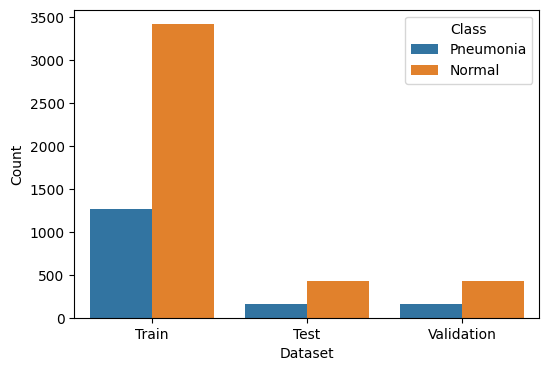

In [4]:
def label_names(labels):
    return ['Pneumonia' if i == 0 else 'Normal' for i in labels]

y_train = label_names(train.labels)
y_test = label_names(test.labels)
y_val = label_names(val.labels)

df = pd.concat([
    pd.DataFrame({'Class': y_train, 'Set': 'Train'}),
    pd.DataFrame({'Class': y_test, 'Set': 'Test'}),
    pd.DataFrame({'Class': y_val, 'Set': 'Validation'}),
])

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Set', hue='Class')#, stat='percent')

plt.xlabel('Dataset')
plt.ylabel('Count')
plt.show()

In [5]:
model = keras.models.Sequential()

# input layer
model.add(Input(shape=(image_size, image_size, 3)))

# block 1
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

# block 2
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

# block 3
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(3, 3), padding='same'))

# block 4
model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(3, 3), padding='same'))

# block 5
model.add(Conv2D(1024, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
model.add(Dropout(0.4))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(3, 3), padding='same'))

# block dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

# output layer
model.add(Dense(2, activation='softmax'))

# final model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# model.summary()

2024-05-31 16:29:20.676568: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-31 16:29:20.676601: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: alpha
2024-05-31 16:29:20.676604: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: alpha
2024-05-31 16:29:20.676857: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.78.0
2024-05-31 16:29:20.676871: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.78  Release Build  (archlinux-builder@)  
GCC version:  gcc version 14.1.1 20240522 (GCC) 
"


In [6]:
num_epochs = 50

early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    verbose=1,
    factor=0.8,
    mode="auto",
    epsilon=0.0001,
    min_lr=0.000001,
)
checkpoint = keras.callbacks.ModelCheckpoint(
    "model-checkpoint.keras",
    monitor="val_loss",
    verbose=1,
    mode="min",
    save_best_only=True,
)

# model = tf.keras.models.load_model("model-checkpoint.keras")  # load checkpoint model
history = model.fit(
    train,
    epochs=num_epochs,
    validation_data=val,
    callbacks=[checkpoint, early, learning_rate_reduction],
)

loss, accuracy = model.evaluate(test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.4f}")

Epoch 1/50


/home/borroot/Sync/courses/virtualenv-courses/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8583 - loss: 0.3271
Epoch 1: val_loss improved from inf to 1.80128, saving model to model-checkpoint.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.8583 - loss: 0.3269 - val_accuracy: 0.7299 - val_loss: 1.8013 - learning_rate: 1.0000e-04
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9230 - loss: 0.2019
Epoch 2: val_loss improved from 1.80128 to 0.20734, saving model to model-checkpoint.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.9230 - loss: 0.2019 - val_accuracy: 0.9231 - val_loss: 0.2073 - learning_rate: 1.0000e-04
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9186 - loss: 0.1901
Epoch 3: val_loss did not improve from 0.20734
293/293 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.9186 - loss: 0.1901 - val_accuracy: 0.9248 - val_loss: 0.2378 - learning_rate: 1.0000e-04
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9362 - loss: 0.1674
Epoch 4:

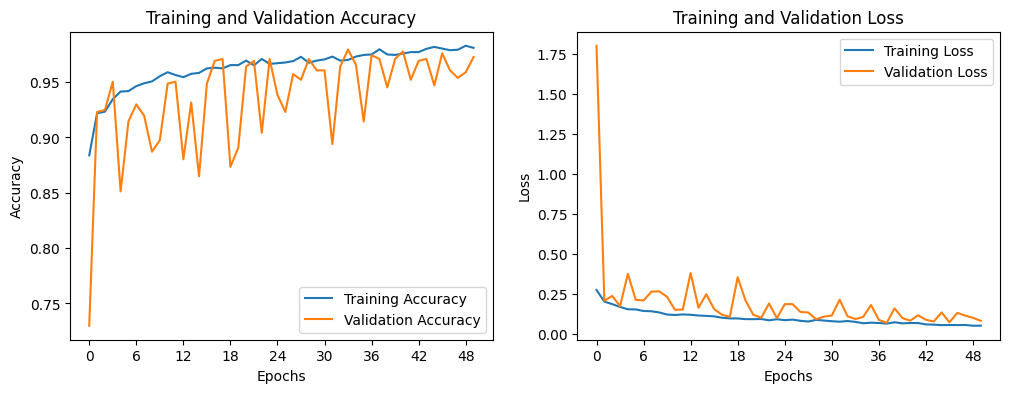

In [7]:
epochs = list(range(len(history.history['accuracy'])))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot accuracy
ax[0].plot(epochs, history.history['accuracy'], label="Training Accuracy")
ax[0].plot(epochs, history.history['val_accuracy'], label="Validation Accuracy")
ax[0].set_title("Training and Validation Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# plot loss
ax[1].plot(epochs, history.history['loss'], label="Training Loss")
ax[1].plot(epochs, history.history['val_loss'], label="Validation Loss")
ax[1].set_title("Training and Validation Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

# force integer xlabels
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step


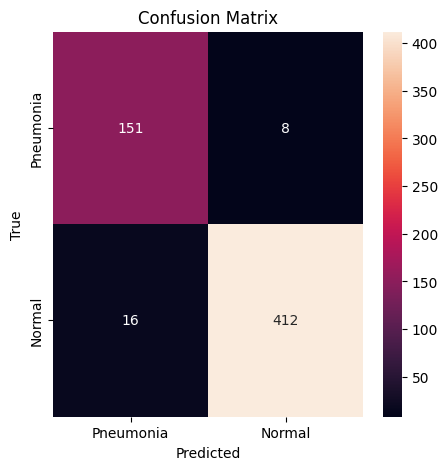

              precision    recall  f1-score   support

   Pneumonia       0.90      0.95      0.93       159
      Normal       0.98      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



In [11]:
y_pred = np.argmax(model.predict(test), axis=1)
y_true = test.classes

cm = confusion_matrix(y_true, y_pred)
labels = ["Pneumonia", "Normal"]

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))